Imagine standing at the check-out counter at the grocery store with a long line behind you and the cashier not-so-quietly announces that your card has been declined. As you step aside, embarrassed, and allow the cashier to tend to the next customer, you receive a text message from your credit card company: "Press 1 if you really tried to spend $500 on cheddar cheese."

Institute of Electrical and Electronics Engineers Computational Intelligence Society (IEEE-CIS) wants to improve this fraud prevention system and the customer experience, improving the efficacy of fradulent transaction alerts for people around the world and helping businesses reduce their fraud loss and increase their revenue. With higher accuracy fraud detection, you can get on with your snacks without the hassle.

The following data was provided by Vesta Corporation, the forerunner in guaranteed e-commerce payment solutions.

# Load the required libraries

In [88]:
# libraries for data cleaning and visualizations
import pandas as pd
from data_sampling import data_sampling
from data_processing_cleaning import *
import matplotlib.pyplot as plt
import seaborn as sns
from visualizations import *
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

# libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from training import *
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, f1_score, precision_score, f1_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the Main data set

In [2]:
# data_transaction_all = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
# data_identity_all = pd.read_csv('ieee-fraud-detection/train_identity.csv')

### Get a sample dataset from the main dataset

Due to time restraints, we only used 10% of the data. We stratified the sample to have the same distribution of fraud and not fraud datasets as the original.

In [3]:
# data_sampling(data_transaction_all, data_identity_all, sampling_number=50000)
# del data_transaction_all, data_identity_all
df_IEEE = pd.read_csv('Data/Sampled_IEEE_data.csv')
df_IEEE.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,had_id
0,3489170,0,13173065,107.95,W,7919,194.0,150.0,mastercard,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3091870,0,2077368,105.95,W,16132,111.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3366827,0,9499922,67.95,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3556300,0,15103578,40.00,W,7069,111.0,150.0,mastercard,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3044040,0,1311752,69.48,W,10972,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Clean the data for plotting and EDA
df_IEEE = data_cleaning_for_EDA(df_IEEE)

### Fraud or No Fraud?

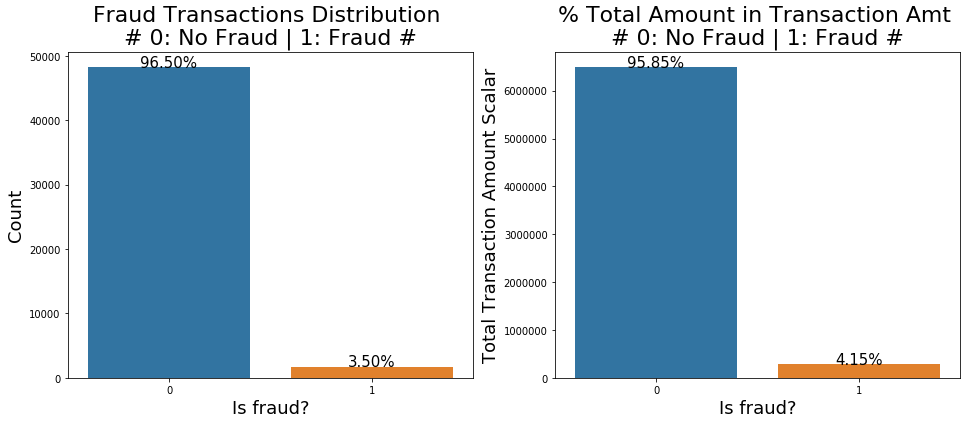

In [9]:
# What are the distributions of fraud and no fraud transactions?
plot_distributions_target(df_IEEE)

As seen, the dataset is highly imbalanced and about 96.5% of the data belongs to the "No Fraud" class.

In addition, about 95.6% of the total transactions are not fraud while 4.15% of transactions are fraud.

# Feature Engineering and Training 

### Prepare data for modeling

In [2]:
df_IEEE = pd.read_csv('Data/Sampled_IEEE_data.csv')

y = df_IEEE['isFraud']
X = df_IEEE.drop(columns='isFraud', axis=1)

In [3]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=1985)

In [ ]:
del df_IEEE

### Feature Engineering

In [4]:
# This function is used to generate new features
# Note that this function deals with train and test datasets to prevent form data leakage
X_train, X_test = Feature_Engineering(X_train, X_test)

### Principal Component Analysis for Dimensionality Reduction

There are about 339 vesta-engineered features in the data (we do not have information on what these variables actually mean due to security purposes). We are going to use Principal Component Analysis (PCA) to reduce the dimension of these features.

Principal Component Analysis:

- Combines all of the features into a given number of new features (10 in our case) using an algorithm that drops the least important variables while still retaining the most valuable parts. 

In [5]:
# features started with v
v_features = X_train.columns[54:393]
v_features = ['V' + str(i) for i in range(1, 340)]

The explained variance using 10 components is 95.0%


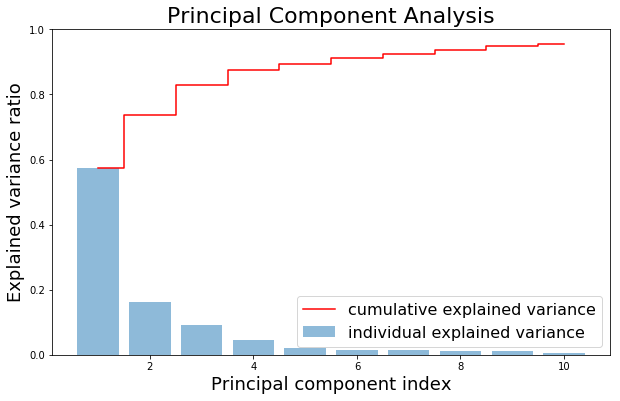

In [6]:
X_train, X_test = PCA_Dimensionality_Reduction(X_train.copy(),
                                               X_test.copy(),
                                               v_features,
                                               n_components=10,
                                               plot_pca=True)

As seen using 10 components explains more than 95.0% of the variability in the data.

Hence, we use the 10 first principal components, instead of 339 v features, in dataframe.

### Missing Values

#### Drop columns with more than 90% missing values

In [8]:
X_train, X_test = data_cleaning_for_training(X_train, X_test)

#### Dealing with the rest of missing values

In [9]:
# Filling the rest of missing values
X_train, X_test = fill_na_values(X_train, X_test)

### Convert categorical variable into dummy/indicator variables.

In [10]:
X_train_dummy, X_test_dummy = Convert_categorical_variables(X_train, X_test)
X_train_LabelEncoder, X_test_LabelEncoder = Convert_LabelEncoder(
    X_train.copy(), X_test.copy())

(37500, 299) (12500, 299)
(37500, 100) (12500, 100)


# Training

## Logistic Regression

We first performed the logistic regression classification technique, which predicts the probability that a given data entry belongs to the category "1".

### Training using logistic regression with the results of pd.get_dummies

We use a one-hot encoding method pd.get_dummies to convert categorical variable into indicator variables using 0 and 1.

In [37]:
run_status = False
if run_status:
    model_logistic_dummy, y_pred_logistic_dummy = logistic_regression_param_selection(X_train_dummy,
                                                                                      X_test_dummy,
                                                                                      y_train,
                                                                                      y_test,
                                                                                      nfolds=5,
                                                                                      n_jobs=-1)
    results_LG_dummy = pd.DataFrame(y_test)
    results_LG_dummy.columns = ['Obs']
    results_LG_dummy['pred'] = list(y_pred_logistic_dummy)
    results_LG_dummy.to_csv('Data/y_pred_logistic_dummy.csv')
    # save the model to disk
    filename = 'model_logistic_dummy.sav'
    pickle.dump(model_logistic_dummy, open(filename, 'wb'))

-------------------------- Results for Logistic Regression (pd.get_dummies) --------------------------
roc_auc_score for test set is: 0.57
recall_score for test set is: 0.14
precision_score for test set is: 0.41
f1_score for test set is: 0.21
accuracy_score for test set is: 0.96


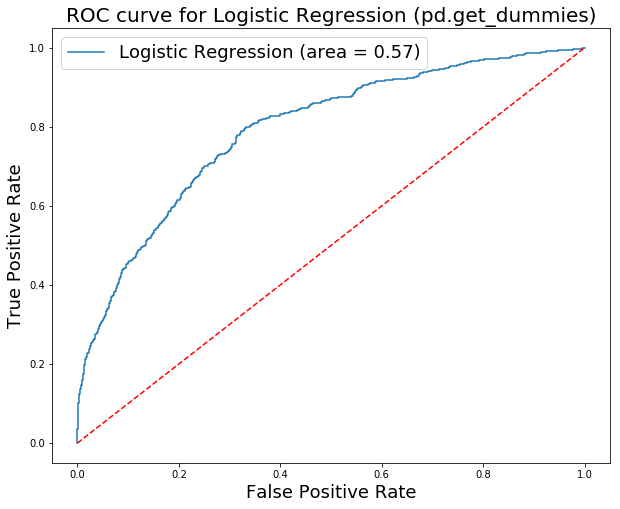

In [112]:
# load the model
y_obs = y_test
filename = 'Data/model_logistic_dummy.sav'
X = X_test_dummy
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X)
model_name = 'Logistic Regression (pd.get_dummies)'
print(f'--------------------- Results for {model_name} ---------------------')
print('roc_auc_score for test set is:',
      round(roc_auc_score(y_test, y_pred), 2))
print('recall_score for test set is:', round(recall_score(y_test, y_pred), 2))
print('precision_score for test set is:',
      round(precision_score(y_test, y_pred), 2))
print('f1_score for test set is:', round(f1_score(y_test, y_pred), 2))
print('accuracy_score for test set is:',
      round(accuracy_score(y_test, y_pred), 2))
plot_roc_curve(X=X,
               y_obs=y_obs,
               models=[loaded_model],
               title_name=f'ROC curve for {model_name}')

### Training using logistic regression with the results of LabelEncoder

We use a different encoding method LabelEncoder to convert the labels into numeric form using numbers 0 to the number of labels.

In [38]:
run_status = False
if run_status:
    model_logistic_LabelEncoder, y_pred_logistic_LabelEncoder = logistic_regression_param_selection(X_train_LabelEncoder,
                                                                                                    X_test_LabelEncoder,
                                                                                                    y_train,
                                                                                                    y_test,
                                                                                                    nfolds=5,
                                                                                                    n_jobs=-1)
    results_LG_LabelEncoder = pd.DataFrame(y_test)
    results_LG_LabelEncoder.columns = ['Obs']
    results_LG_LabelEncoder['pred'] = list(y_pred_logistic_LabelEncoder)
    results_LG_LabelEncoder.to_csv('Data/y_pred_logistic_LabelEncoder.csv')
    # save the model to disk
    filename = 'model_logistic_LabelEncoder.sav'
    pickle.dump(model_logistic_LabelEncoder, open(filename, 'wb'))

-------------------------- Results for Logistic Regression (LabelEncoder) --------------------------
roc_auc_score for test set is: 0.56
recall_score for test set is: 0.13
precision_score for test set is: 0.51
f1_score for test set is: 0.2
accuracy_score for test set is: 0.97


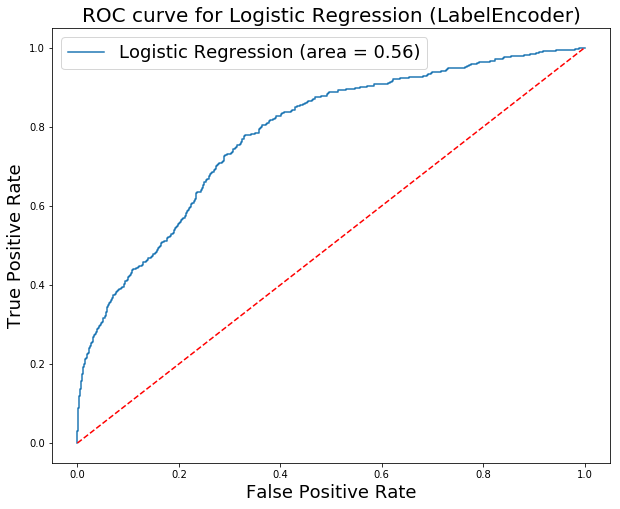

In [113]:
# load the model
y_obs = y_test
filename = 'Data/model_logistic_LabelEncoder.sav'
X = X_test_LabelEncoder
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X)
model_name = 'Logistic Regression (LabelEncoder)'
print(f'--------------------- Results for {model_name} ---------------------')
print('roc_auc_score for test set is:',
      round(roc_auc_score(y_test, y_pred), 2))
print('recall_score for test set is:', round(recall_score(y_test, y_pred), 2))
print('precision_score for test set is:',
      round(precision_score(y_test, y_pred), 2))
print('f1_score for test set is:', round(f1_score(y_test, y_pred), 2))
print('accuracy_score for test set is:',
      round(accuracy_score(y_test, y_pred), 2))
plot_roc_curve(X=X,
               y_obs=y_obs,
               models=[loaded_model],
               title_name=f'ROC curve for {model_name}')

## Random Forest

We then performed the random forest classification technique, which creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of which features are most important.

### Training using random forest with the results of pd.get_dummies

In [43]:
run_status = False
if run_status:
    model_RF_dummy, y_pred_RF_dummy = random_forest_param_selection(X_train_dummy,
                                                                    X_test_dummy,
                                                                    y_train,
                                                                    y_test,
                                                                    nfolds=5,
                                                                    n_jobs=-1)
    results_RF_dummy = pd.DataFrame(y_test)
    results_RF_dummy.columns = ['Obs']
    results_RF_dummy['pred'] = list(y_pred_RF_dummy)
    results_RF_dummy.to_csv('Data/y_pred_RF_dummy.csv')
    # save the model to disk
    filename = 'model_RF_dummy.sav'
    pickle.dump(model_RF_dummy, open(filename, 'wb'))

The training roc_auc_score is: 0.821
The best parameters are: {'RF__n_estimators': 2000, 'RF__min_samples_split': 5, 'RF__min_samples_leaf': 2, 'RF__max_features': 'sqrt', 'RF__max_depth': 30, 'RF__bootstrap': True}
The test roc_auc_score is: 0.5


-------------------------- Results for Random Forest (pd.get_dummies) --------------------------
roc_auc_score for test set is: 0.63
recall_score for test set is: 0.26
precision_score for test set is: 0.84
f1_score for test set is: 0.4
accuracy_score for test set is: 0.97


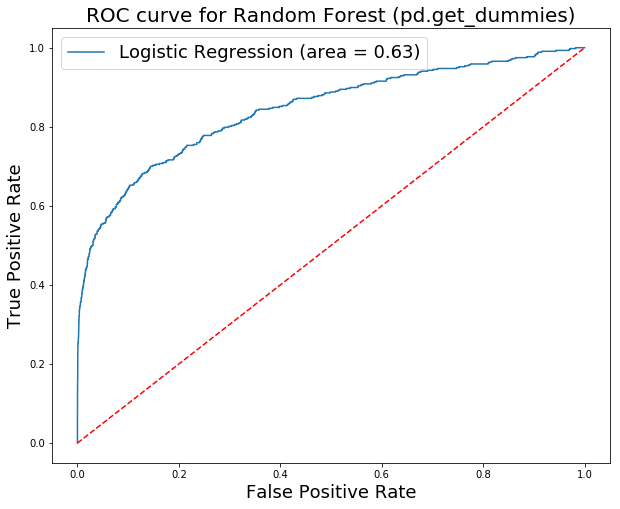

In [108]:
# load the model
y_obs = y_test
filename = 'Data/model_RF_dummy.sav'
X = X_test_dummy
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X)
model_name = 'Random Forest (pd.get_dummies)'
print(f'--------------------- Results for {model_name} ---------------------')
print('roc_auc_score for test set is:',
      round(roc_auc_score(y_test, y_pred), 2))
print('recall_score for test set is:', round(recall_score(y_test, y_pred), 2))
print('precision_score for test set is:',
      round(precision_score(y_test, y_pred), 2))
print('f1_score for test set is:', round(f1_score(y_test, y_pred), 2))
print('accuracy_score for test set is:',
      round(accuracy_score(y_test, y_pred), 2))
plot_roc_curve(X=X,
               y_obs=y_obs,
               models=[loaded_model],
               title_name=f'ROC curve for {model_name}')

### Training using random forest with the results of LabelEncoder

In [109]:
run_status = False
if run_status:
    model_RF_LabelEncoder, y_pred_RF_LabelEncoder = random_forest_param_selection(X_train_LabelEncoder,
                                                                                  X_test_LabelEncoder,
                                                                                  y_train,
                                                                                  y_test,
                                                                                  nfolds=5,
                                                                                  n_jobs=-1)
    results_RF_LabelEncoder = pd.DataFrame(y_test)
    results_RF_LabelEncoder.columns = ['Obs']
    results_RF_LabelEncoder['pred'] = list(y_pred_RF_LabelEncoder)
    results_RF_LabelEncoder.to_csv('Data/y_pred_RF_LabelEncoder.csv')
    # save the model to disk
    filename = 'model_RF_LabelEncoder.sav'
    pickle.dump(model_RF_LabelEncoder, open(filename, 'wb'))

-------------------------- Results for Random Forest (LabelEncoder) --------------------------
roc_auc_score for test set is: 0.62
recall_score for test set is: 0.25
precision_score for test set is: 0.87
f1_score for test set is: 0.39
accuracy_score for test set is: 0.97


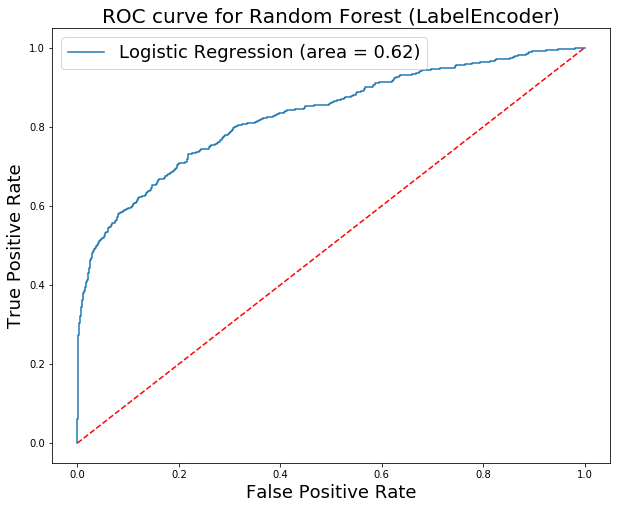

In [111]:
y_obs = y_test
filename = 'Data/model_RF_LabelEncoder.sav'
X = X_test_LabelEncoder
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X)
model_name = 'Random Forest (LabelEncoder)'
print(f'--------------------- Results for {model_name} ---------------------')
print('roc_auc_score for test set is:',
      round(roc_auc_score(y_test, y_pred), 2))
print('recall_score for test set is:', round(recall_score(y_test, y_pred), 2))
print('precision_score for test set is:',
      round(precision_score(y_test, y_pred), 2))
print('f1_score for test set is:', round(f1_score(y_test, y_pred), 2))
print('accuracy_score for test set is:',
      round(accuracy_score(y_test, y_pred), 2))
plot_roc_curve(X=X,
               y_obs=y_obs,
               models=[loaded_model],
               title_name=f'ROC curve for {model_name}')

### Logistic or Random Forest?

We compared the results of the two classification techniques used.

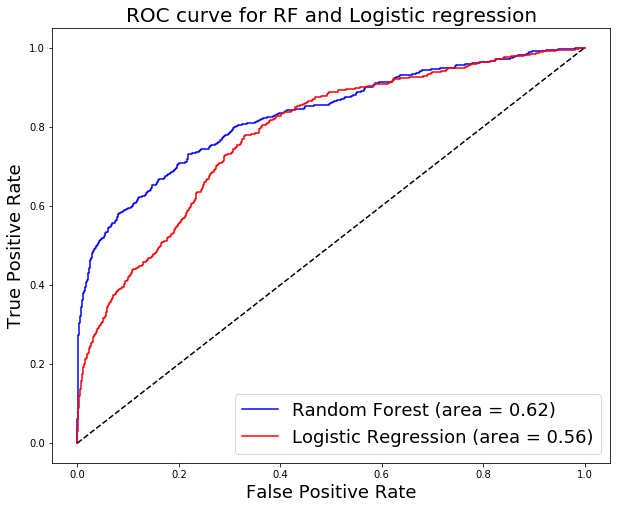

In [130]:
y_obs = y_test
filename_RF = 'Data/model_RF_LabelEncoder.sav'
filename_logisstic = 'Data/model_logistic_LabelEncoder.sav'
X = X_test_LabelEncoder
# load the model from disk
loaded_model_RF = pickle.load(open(filename_RF, 'rb'))
loaded_model_logisstic = pickle.load(open(filename_logisstic, 'rb'))
model_name = 'RF and Logistic regression'
plot_roc_curve(X=X,
               y_obs=y_obs,
               models=[loaded_model_RF, loaded_model_logisstic],
               title_name=f'ROC curve for {model_name}',
               legend_names=['Random Forest', 'Logistic Regression'],
               colors=['b', 'r'])

As you can see above in the ROC curve, the two classification techniques did not perform well, but Random Forest performed slightly better.

## Dealing with imbalanced dataset

### 1. Oversampling the minority class
Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when there are not a large number of data points to work with.

In [149]:
X_train_LabelEncoder_over, y_train_over = imbalance_sampling_data(X_train_LabelEncoder,
                                                                  y_train,
                                                                  sampling_method='Oversampling')

In [114]:
run_status = False
if run_status:
    model_RF_dummy_over, y_pred_RF_LabelEncoder_over = random_forest_param_selection(X_train_LabelEncoder_over,
                                                                                     X_test_LabelEncoder,
                                                                                     y_train_over,
                                                                                     y_test,
                                                                                     nfolds=5,
                                                                                     n_jobs=-1)
    results_RF_LabelEncoder_over = pd.DataFrame(y_test)
    results_RF_LabelEncoder_over.columns = ['Obs']
    results_RF_LabelEncoder_over['pred'] = list(y_pred_RF_LabelEncoder_over)
    results_RF_LabelEncoder_over.to_csv('Data/y_pred_RF_LabelEncoder_over.csv')
    # save the model to disk
    filename = 'model_RF_dummy_over.sav'
    pickle.dump(model_RF_dummy_over, open(filename, 'wb'))

-------------------------- Results for Random Forest (Oversampling) --------------------------
roc_auc_score for test set is: 0.56
recall_score for test set is: 0.11
precision_score for test set is: 0.92
f1_score for test set is: 0.2
accuracy_score for test set is: 0.97


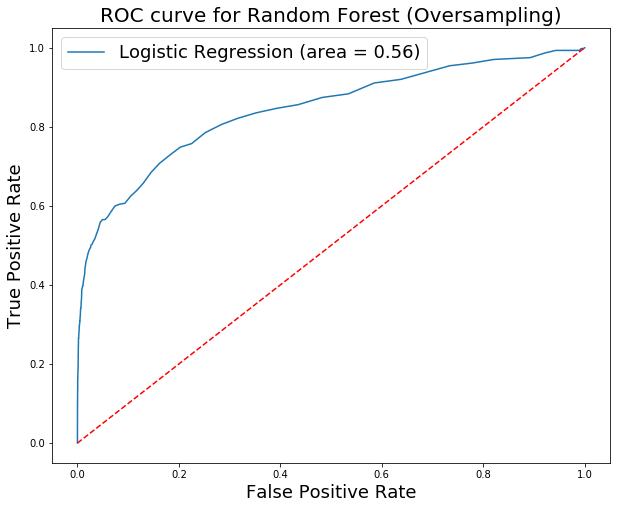

In [115]:
y_obs = y_test
filename = 'Data/model_RF_dummy_over.sav'
X = X_test_LabelEncoder
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X)
model_name = 'Random Forest (Oversampling)'
print(f'--------------------- Results for {model_name} ---------------------')
print('roc_auc_score for test set is:',
      round(roc_auc_score(y_test, y_pred), 2))
print('recall_score for test set is:', round(recall_score(y_test, y_pred), 2))
print('precision_score for test set is:',
      round(precision_score(y_test, y_pred), 2))
print('f1_score for test set is:', round(f1_score(y_test, y_pred), 2))
print('accuracy_score for test set is:',
      round(accuracy_score(y_test, y_pred), 2))
plot_roc_curve(X=X,
               y_obs=y_obs,
               models=[loaded_model],
               title_name=f'ROC curve for {model_name}')

### 2. Undersampling the majority class
Undersampling can be defined as removing some observations of the majority class. Undersampling can be a good choice when there is a large number of datapoints for training.

The drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set.

In [11]:
X_train_LabelEncoder_under, y_train_under = imbalance_sampling_data(X_train_LabelEncoder,
                                                                    y_train,
                                                                    sampling_method='Undersampling')

In [12]:
run_status = True
if run_status:
    model_RF_LabelEncoder_under, y_pred_RF_LabelEncoder_under = random_forest_param_selection(X_train_LabelEncoder_under,
                                                                                              X_test_LabelEncoder,
                                                                                              y_train_under,
                                                                                              y_test,
                                                                                              nfolds=5,
                                                                                              n_jobs=None)
    results_RF_LabelEncoder_under = pd.DataFrame(y_test)
    results_RF_LabelEncoder_under.columns = ['Obs']
    results_RF_LabelEncoder_under['pred'] = list(y_pred_RF_LabelEncoder_under)
    results_RF_LabelEncoder_under.to_csv(
        'Data/y_pred_RF_LabelEncoder_under.csv')
    # save the model to disk
    filename = 'model_RF_LabelEncoder_under.sav'
    pickle.dump(model_RF_LabelEncoder_under, open(filename, 'wb'))

The training roc_auc_score is: 0.875
The best parameters are: {'n_estimators': 670, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': False}
The test roc_auc_score is: 0.73


-------------------------- Results for Random Forest (Undersampling) --------------------------
roc_auc_score for test set is: 0.74
recall_score for test set is: 0.85
precision_score for test set is: 0.08
f1_score for test set is: 0.14
accuracy_score for test set is: 0.63


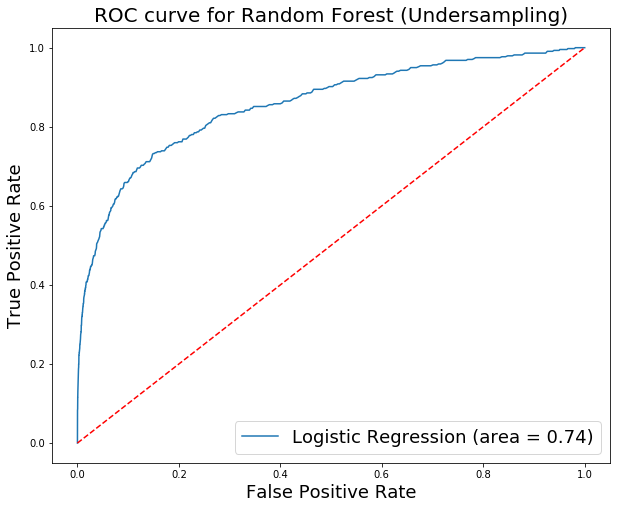

In [116]:
y_obs = y_test
filename = 'Data/model_RF_LabelEncoder_under.sav'
X = X_test_LabelEncoder
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X)
model_name = 'Random Forest (Undersampling)'
print(f'--------------------- Results for {model_name} ---------------------')
print('roc_auc_score for test set is:',
      round(roc_auc_score(y_test, y_pred), 2))
print('recall_score for test set is:', round(recall_score(y_test, y_pred), 2))
print('precision_score for test set is:',
      round(precision_score(y_test, y_pred), 2))
print('f1_score for test set is:', round(f1_score(y_test, y_pred), 2))
print('accuracy_score for test set is:',
      round(accuracy_score(y_test, y_pred), 2))
plot_roc_curve(X=X,
               y_obs=y_obs,
               models=[loaded_model],
               title_name=f'ROC curve for {model_name}')

### 3. Generate synthetic samples
Here we will use the Synthetic Minority Oversampling Technique (SMOTE), an oversampling method that creates new, synthetic samples using a nearest neighbors algorithm.

In [150]:
X_train_LabelEncoder_SMOTE, y_train_SMOTE = imbalance_sampling_data(X_train_LabelEncoder,
                                                                    y_train,
                                                                    sampling_method='SMOTE')

In [ ]:
run_status = False
if run_status:
    model_RF_LabelEncoder_SMOTE, y_pred_RF_LabelEncoder_SMOTE = random_forest_param_selection(X_train_LabelEncoder_SMOTE,
                                                                                              X_test_LabelEncoder,
                                                                                              y_train_SMOTE,
                                                                                              y_test,
                                                                                              nfolds=5,
                                                                                              n_jobs=-1)
    results_RF_LabelEncoder_SMOTE = pd.DataFrame(y_test)
    results_RF_LabelEncoder_SMOTE.columns = ['Obs']
    results_RF_LabelEncoder_SMOTE['pred'] = list(y_pred_RF_LabelEncoder_SMOTE)
    results_RF_LabelEncoder_SMOTE.to_csv(
        'Data/y_pred_RF_LabelEncoder_SMOTE.csv')
    # save the model to disk
    filename = 'model_RF_LabelEncoder_SMOTE.sav'
    pickle.dump(model_RF_LabelEncoder_SMOTE, open(filename, 'wb'))

-------------------------- Results for Random Forest (SMOTE) --------------------------
roc_auc_score for test set is: 0.66
recall_score for test set is: 0.33
precision_score for test set is: 0.59
f1_score for test set is: 0.42
accuracy_score for test set is: 0.97


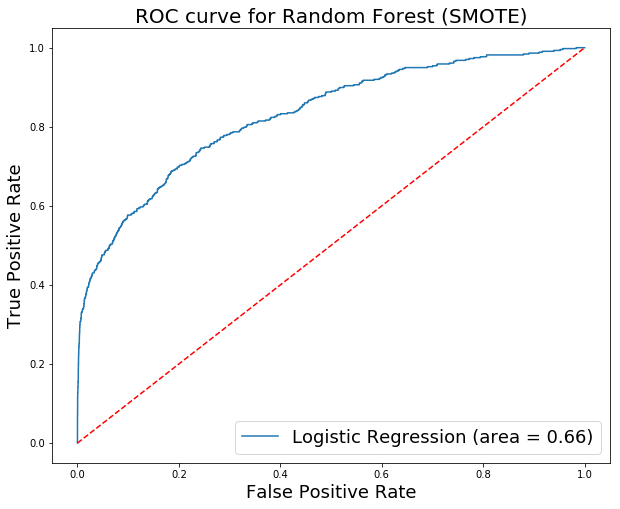

In [117]:
y_obs = y_test
filename = 'Data/model_RF_LabelEncoder_SMOTE.sav'
X = X_test_LabelEncoder
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X)
model_name = 'Random Forest (SMOTE)'
print(f'--------------------- Results for {model_name} ---------------------')
print('roc_auc_score for test set is:',
      round(roc_auc_score(y_test, y_pred), 2))
print('recall_score for test set is:', round(recall_score(y_test, y_pred), 2))
print('precision_score for test set is:',
      round(precision_score(y_test, y_pred), 2))
print('f1_score for test set is:', round(f1_score(y_test, y_pred), 2))
print('accuracy_score for test set is:',
      round(accuracy_score(y_test, y_pred), 2))
plot_roc_curve(X=X,
               y_obs=y_obs,
               models=[loaded_model],
               title_name=f'ROC curve for {model_name}')

### Which sampling Method?

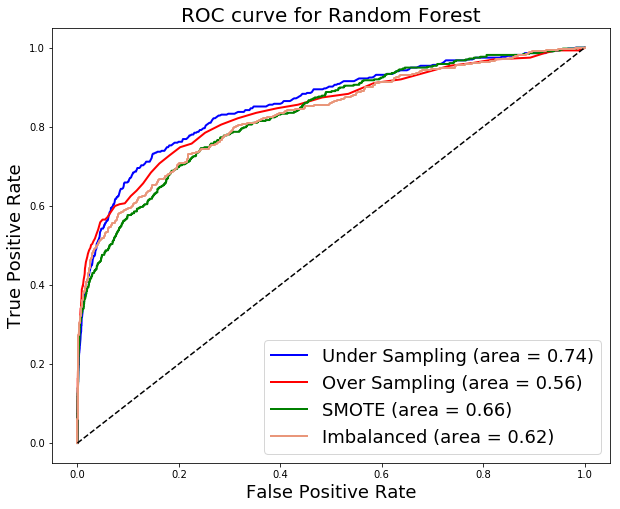

In [132]:
y_obs = y_test
filename_over = 'Data/model_RF_dummy_over.sav'
filename_under = 'Data/model_RF_LabelEncoder_under.sav'
filename_smote = 'Data/model_RF_LabelEncoder_SMOTE.sav'
filename_IMB = 'Data/model_RF_LabelEncoder.sav'

X = X_test_LabelEncoder
# load the model from disk
loaded_model_under = pickle.load(open(filename_under, 'rb'))
loaded_model_over = pickle.load(open(filename_over, 'rb'))
loaded_model_smote = pickle.load(open(filename_smote, 'rb'))
loaded_model_IMB = pickle.load(open(filename_IMB, 'rb'))
model_name = 'Random Forest'
plot_roc_curve(X=X,
               y_obs=y_obs,
               models=[loaded_model_under, loaded_model_over,
                       loaded_model_smote, loaded_model_IMB],
               title_name=f'ROC curve for {model_name}',
               legend_names=['Under Sampling',
                             'Over Sampling', 'SMOTE', "Imbalanced"],
               colors=['b', 'r', 'g', '#E9967A'])

As you can see above in the ROC curve, undersampling method performed the best.

### Result on the whole dataset

We conducted the best performing classification technique on the whole dataset.

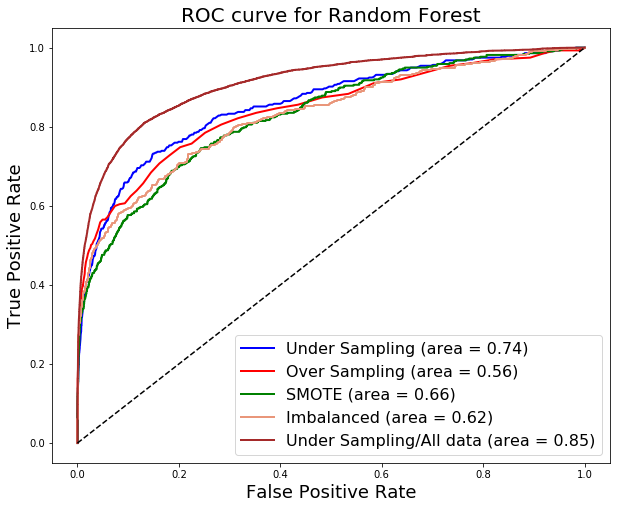

In [144]:
y_obs = y_test
filename_over = 'Data/model_RF_dummy_over.sav'
filename_under = 'Data/model_RF_LabelEncoder_under.sav'
filename_smote = 'Data/model_RF_LabelEncoder_SMOTE.sav'
filename_IMB = 'Data/model_RF_LabelEncoder.sav'

X = X_test_LabelEncoder
# load the model from disk
loaded_model_under = pickle.load(open(filename_under, 'rb'))
loaded_model_over = pickle.load(open(filename_over, 'rb'))
loaded_model_smote = pickle.load(open(filename_smote, 'rb'))
loaded_model_IMB = pickle.load(open(filename_IMB, 'rb'))
model_name = 'Random Forest'
plot_roc_curve(X=X,
               y_obs=y_obs,
               models=[loaded_model_under, loaded_model_over,
                       loaded_model_smote, loaded_model_IMB],
               title_name=f'ROC curve for {model_name}',
               legend_names=['Under Sampling',
                             'Over Sampling', 'SMOTE', "Imbalanced"],
               colors=['b', 'r', 'g', '#E9967A'])